# Import pacakges

In [1]:
import pickle
import spacy
import tomotopy as tp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import RidgeClassifier, LogisticRegression, SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, mean_squared_error, classification_report, confusion_matrix, RocCurveDisplay, f1_score
from tqdm.notebook import tqdm
from gensim.models import Word2Vec, Phrases, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dropout, Activation
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

2023-08-22 07:48:42.357209: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load data

In [2]:
df = pd.read_csv("/Users/irene/Downloads/sportsmaserati_clean.csv")

In [222]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391608 entries, 0 to 391607
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      391608 non-null  int64  
 1   ID              391608 non-null  int64  
 2   Section         391608 non-null  object 
 3   Title           391608 non-null  object 
 4   Comment         391608 non-null  object 
 5   User            391608 non-null  object 
 6   Forum Owner     391608 non-null  object 
 7   Date            391608 non-null  object 
 8   ParentUser      106368 non-null  object 
 9   ParentComment   106368 non-null  object 
 10  ParentID        106368 non-null  float64
 11  Location        265469 non-null  object 
 12  Age             47834 non-null   float64
 13  Message Counts  97835 non-null   float64
 14  Reaction Score  195425 non-null  float64
 15  Points          97835 non-null   float64
dtypes: float64(5), int64(2), object(9)
memory usage: 47.8+ M

# Prepare dataset

In [3]:
df1 = df[["Location", "Comment"]]

In [4]:
# check non value in location
a = df1["Location"].isna().sum()
na = a/len(df1)
na

0.32210526853384

In [5]:
a

126139

In [40]:
# Sample data (replace with your actual data)
import plotly.express as px

europe_users = 202482
non_europe_users = 62987
unknown_users = 126139

# Labels for the pie chart
labels = ['Europe', 'Non-Europe', 'Unknown']

# Sizes for each category
sizes = [europe_users, non_europe_users, unknown_users]

# Custom colors
colors = ['#f02a2a', '#b8b8b8', '#1f3a85']

# Create a pie chart using plotly
fig = px.pie(names=labels, values=sizes, title='Distribution of User Locations in SportMaserati',
             color_discrete_sequence=colors, width=500, height=500)

fig.update_layout(
    font={'family': 'Helvetica', 'size': 12, 'color': 'black'},
    title={'text': 'Distribution of User Locations in SportMaserati', 'font': {'family': 'Helvetica, Arial, sans-serif', 'size': 15},'x': 0.5}
)
# Show the plot
fig.show()

In [4]:
df2 = df1.dropna()

In [5]:
non_eu_countries = ["Hong Kong", "Argentina", "United Arab Emirates", "Canada",
                  "New Zealand", "Bangladesh", "Philippines", "South Africa",
                  "Pakistan", "United States", "Australia"]

In [6]:
df2['europe'] = 1

/var/folders/65/l8gwbbg117z6hscwvjl3vg0m0000gn/T/ipykernel_53224/1823889012.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['europe'] = 1


In [7]:
df2.loc[df2['Location'].isin(non_eu_countries), 'europe'] = 0

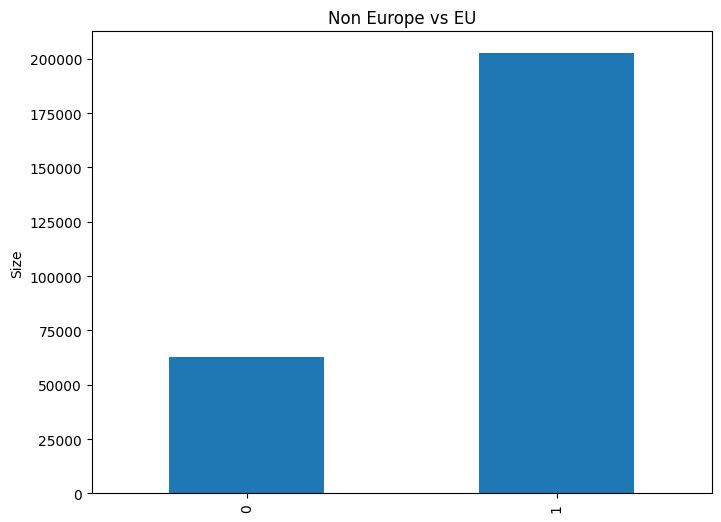

In [62]:
fig, ax = plt.subplots(figsize=(8, 6))
r = df2.groupby(["europe"]).size()
r.plot(kind = "bar", ax = ax)
ax.set_xlabel("")
ax.set_ylabel("Size")
ax.set_title("Non Europe vs EU")
plt.xticks(fontsize=10)
plt.show()

In [63]:
r

europe
0     62987
1    202482
dtype: int64

# NLP pineline

In [ ]:
docs = df2["Comment"]

In [ ]:
nlp = spacy.load("en_core_web_lg")

In [ ]:
docs_tokens = []
tmp = []
for doc in tqdm(docs):
    tmp = [
        token.lemma_.lower()
        for token in nlp(doc)
        if (not token.is_stop) & 
        (not token.is_punct) & 
        (token.is_alpha)
    ]
    
    docs_tokens.append(tmp)

  0%|          | 0/265469 [00:00<?, ?it/s]

In [105]:
# save the list of tokens
with open('sport_location_classifier_tkns.pkl', 'wb') as f:
    pickle.dump(docs_tokens, f)

In [52]:
# load tokens
with open('sport_location_classifier_tkns.pkl', 'rb') as f:
    docs_tokens_loaded = pickle.load(f)

In [53]:
# find bigrams and trigrams

# get rid of common terms
common_terms = [
    u"of",
    u"with",
    u"without",
    u"and",
    u"or",
    u"the",
    u"a",
    u"not",
    "be",
    u"to",
    u"this",
    u"who",
    u"in",
]
# find phrases
bigram = Phrases( # capturing bi-grams
    docs_tokens_loaded,
    min_count=50,
    threshold=5,
    max_vocab_size=50000,
    common_terms=common_terms,
)
trigram = Phrases( # capturing tri-grams
    bigram[docs_tokens_loaded],
    min_count=50,
    threshold=5,
    max_vocab_size=50000,
    common_terms=common_terms,
)

# uncomment if bi-grammed, tokenized document is preferred

# docs_phrased = [bigram[line] for line in docs_tokens]
docs_phrased_brand = [trigram[bigram[line]] for line in docs_tokens_loaded] # tokenized documents and join 
                                                                # the tokens associated with 
                                                                # bi- or tri-grams.

# Split the data

In [54]:
test = [' '.join(t) for t in docs_phrased_brand]

In [64]:
df3 = df2.copy()
df3['Comment'] = test

In [65]:
X = df3["Comment"]
Y = df3["europe"]

In [117]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 265469 entries, 0 to 391607
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Location  265469 non-null  object
 1   Comment   265469 non-null  object
 2   europe    265469 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 8.1+ MB


In [14]:
x_train, x_other, y_train, y_other = train_test_split(X, Y, test_size=0.2, random_state=243)
print(x_train.shape, x_other.shape)
print(y_train.shape, y_other.shape)

x_test, x_val, y_test, y_valid = train_test_split(x_other, y_other, test_size=0.2, random_state=243)
print(x_test.shape, x_val.shape)
print(y_test.shape, y_valid.shape)

(212375,) (53094,)
(212375,) (53094,)
(42475,) (10619,)
(42475,) (10619,)


# 1. BoW

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
x_train_cv = cv.fit_transform(x_train)
x_test_cv = cv.transform(x_other)

## 1.1 Native bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(x_train_cv, y_train)

MultinomialNB()

In [ ]:
y_pred_nb = nb.predict(x_test_cv)
print("Test accuracy", accuracy_score(y_other,y_pred_nb)*100)
print("F1 Score:", f1_score(y_other,y_pred_nb, average='macro'))
print(classification_report(y_other,y_pred_nb))

Test accuracy 77.85625494406148
F1 Score: 0.5778701684013416


## 1.2 Logi

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x_train_cv, y_train)

/opt/anaconda3/envs/NLP/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
# generate predictions
lr_pre = lr.predict(x_test_cv)

In [ ]:
print("Test accuracy", accuracy_score(y_other,lr_pre)*100)
print("F1 Score:", f1_score(y_other,lr_pre, average='macro'))
print(classification_report(y_other,lr_pre))

Test accuracy 78.01446491128942
F1 Score: 0.589494430877848


# 2. TFIDF

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
x_train_tfidf = tfidf.fit_transform(x_train)
x_test_tfidf = tfidf.transform(x_other)

## 2.1 Native bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
tfidf_nb = MultinomialNB()
tfidf_nb.fit(x_train_tfidf, y_train)

MultinomialNB()

In [ ]:
y_pred_nb_tfidf = tfidf_nb.predict(x_test_tfidf)
print("Test accuracy", accuracy_score(y_other,y_pred_nb_tfidf)*100)
print("F1 Score:", f1_score(y_other,y_pred_nb_tfidf, average='macro'))
print(classification_report(y_other,y_pred_nb_tfidf))

Test accuracy 76.81470599314424
F1 Score: 0.4557258401806413


## 2.2 Logi

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x_train_tfidf, y_train)

/opt/anaconda3/envs/NLP/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
# generate predictions
lr_pre = lr.predict(x_test_tfidf)

In [ ]:
print("Test accuracy", accuracy_score(y_other,lr_pre)*100)
print("F1 Score:", f1_score(y_other,lr_pre, average='macro'))
print(classification_report(y_other,lr_pre))

Test accuracy 77.83365352017178
F1 Score: 0.5424290829239105


## 2.3 Ridge

In [95]:
#### Prepar the parameter value list for tuning
#### Set the range of Grid Search
param_grid = {'alpha': [0.1, 1, 10]}

#### Train the Ridge Classification model
ridge_c = RidgeClassifier()
# Use GridSearch to tune the hyperparameter
ridge_c = GridSearchCV(ridge_c, param_grid, cv=5)
ridge_c.fit(x_train_tfidf, y_train)
# check the value of alpha
best_alpha_ridge = ridge_c.best_params_['alpha']
print(f"Best alpha for Ridge Regression: {best_alpha_ridge}")
# predict the test result
predictions_ridge = ridge_c.predict(x_test_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_other, predictions_ridge))
print("F1 Score:", f1_score(y_other, predictions_ridge, average='macro'))
print(classification_report(y_other, predictions_ridge))

Best alpha for Ridge Regression: 1
Accuracy: 0.7804083323916073
F1 Score: 0.569223172358587
              precision    recall  f1-score   support

           0       0.63      0.17      0.27     12535
           1       0.79      0.97      0.87     40559

    accuracy                           0.78     53094
   macro avg       0.71      0.57      0.57     53094
weighted avg       0.75      0.78      0.73     53094



# 3. Word2vec

In [19]:
from gensim.models import Word2Vec

sentences = [sentence.split() for sentence in x_train]
w2v_model = Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)

In [20]:
import numpy as np

def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

x_train_w2v = np.array([vectorize(sentence) for sentence in x_train])
x_test_w2v = np.array([vectorize(sentence) for sentence in x_other])

## 3.1 Logi

In [21]:
clf = LogisticRegression()
clf.fit(x_train_w2v, y_train)

LogisticRegression()

In [22]:
# generate predictions
lr_pre = clf.predict(x_test_w2v)
print("Test accuracy", accuracy_score(y_other,lr_pre)*100)
print("F1 Score:", f1_score(y_other,lr_pre, average='macro'))
print(classification_report(y_other,lr_pre))

Test accuracy 76.34384299544205
F1 Score: 0.43641882308278757
              precision    recall  f1-score   support

           0       0.39      0.00      0.01     12535
           1       0.76      1.00      0.87     40559

    accuracy                           0.76     53094
   macro avg       0.58      0.50      0.44     53094
weighted avg       0.68      0.76      0.66     53094



# 4. Doc2vec

In [44]:
# convert data into Doc2Vec required format
tgd_X = [TaggedDocument(d, [i]) for i, d in enumerate(docs_phrased_brand)]

# train Doc2Vec model
model = Doc2Vec(tgd_X, vector_size=100, min_count=1, workers=4, epochs=100)

# get Doc2Vec vectors
vectors = [model.infer_vector(x) for x in tqdm(docs_phrased_brand)]
vectors = [x.tolist() for x in vectors]

# train-test split
X_other, X_test, y_other, y_test = train_test_split(vectors, Y, test_size=0.2,random_state = 11)

  0%|          | 0/265469 [00:00<?, ?it/s]

In [45]:
clf = LogisticRegression()
clf.fit(X_other, y_other)

LogisticRegression()

In [47]:
# generate predictions
lr_pre = clf.predict(X_test)
print("Test accuracy", accuracy_score(y_test,lr_pre)*100)
print("F1 Score:", f1_score(y_test,lr_pre, average='macro'))
print(classification_report(y_test,lr_pre))

Test accuracy 76.13666327645309
F1 Score: 0.4370151116640527
              precision    recall  f1-score   support

           0       0.44      0.00      0.01     12652
           1       0.76      1.00      0.86     40442

    accuracy                           0.76     53094
   macro avg       0.60      0.50      0.44     53094
weighted avg       0.68      0.76      0.66     53094



# Combine sport with maseratilife

In [8]:
ml = pd.read_csv("/Users/irene/Downloads/Maseratilife_merged_df.csv")

In [9]:
sp = df2.copy()

# Prepare dataset

In [10]:
ml1 = ml[["user_continent", "content"]]

In [23]:
# check non value in location
a = ml1["user_continent"].isna().sum()
na = a/len(ml1)
na

0.440365620942351

In [24]:
a

128537

In [35]:
# Sample data (replace with your actual data)
import plotly.express as px

europe_users = 15592
non_europe_users = 146150
unknown_users = 128537

# Labels for the pie chart
labels = ['Europe', 'Non-Europe', 'Unknown']

# Sizes for each category
sizes = [europe_users, non_europe_users, unknown_users]

# Custom colors
colors = ['#1f3a85', '#b8b8b8', '#f02a2a']

# Create a pie chart using plotly
fig = px.pie(names=labels, values=sizes, title='Distribution of User Locations in MaseratiLife',
             color_discrete_sequence=colors, width=500, height=500)

fig.update_layout(
    font={'family': 'Helvetica', 'size': 12, 'color': 'black'},
    title={'text': 'Distribution of User Locations in MaseratiLife', 'font': {'family': 'Helvetica, Arial, sans-serif', 'size': 15},'x': 0.5}
)
# Show the plot
fig.show()

In [11]:
ml2 = ml1.dropna()

In [12]:
non_eu_countries = ['Asia', 'North America', 'Australia', 'South America', 'Africa']

In [13]:
ml2['europe'] = 1

/var/folders/65/l8gwbbg117z6hscwvjl3vg0m0000gn/T/ipykernel_53224/3374546162.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ml2['europe'] = 1


In [14]:
ml2.loc[ml2['user_continent'].isin(non_eu_countries), 'europe'] = 0

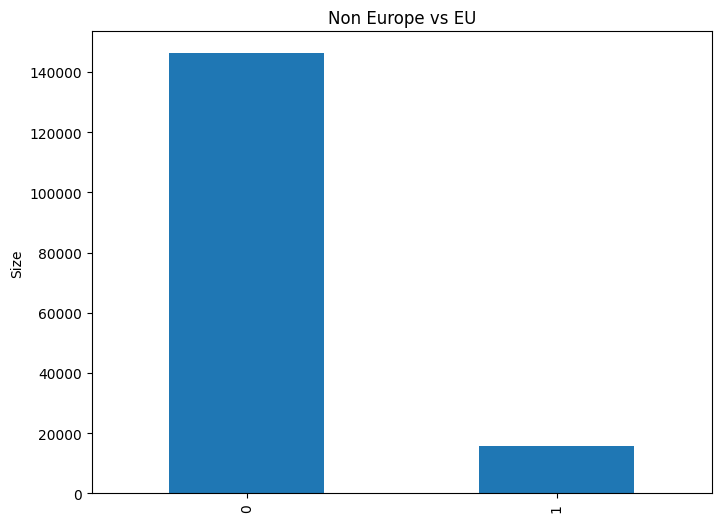

In [46]:
fig, ax = plt.subplots(figsize=(8, 6))
r = ml2.groupby(["europe"]).size()
r.plot(kind = "bar", ax = ax)
ax.set_xlabel("")
ax.set_ylabel("Size")
ax.set_title("Non Europe vs EU")
plt.xticks(fontsize=10)
plt.show()

In [47]:
r

europe
0    146150
1     15592
dtype: int64

In [64]:
ml3 = ml2[["content","europe"]]
sp1 = sp[["Comment", "europe"]]

In [65]:
ml3 = ml3.rename(columns={"content": "Comment"})

In [17]:
# ml2 / sp
data_list = [ml3, sp1]
merged = pd.concat(data_list)

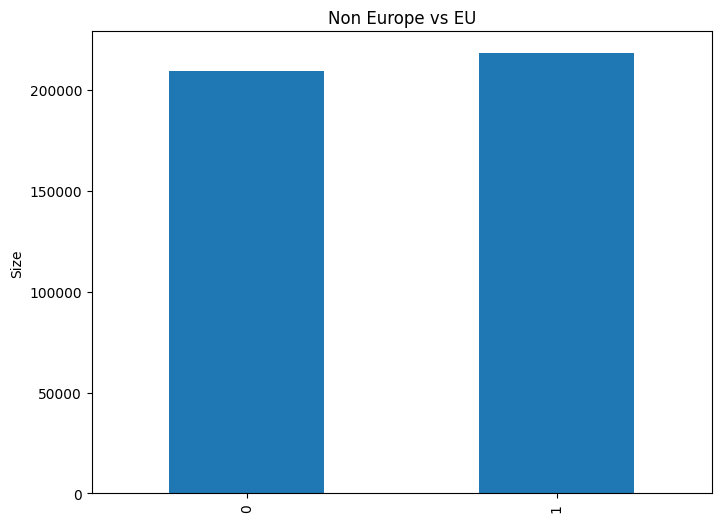

In [71]:
fig, ax = plt.subplots(figsize=(8, 6))
r = merged.groupby(["europe"]).size()
r.plot(kind = "bar", ax = ax)
ax.set_xlabel("")
ax.set_ylabel("Size")
ax.set_title("Non Europe vs EU")
plt.xticks(fontsize=10)
plt.show()

In [72]:
r

europe
0    209137
1    218074
dtype: int64

In [77]:
# Sample data (replace with your actual data)
import plotly.express as px

europe_users = 218074
non_europe_users = 209137

# Labels for the pie chart
labels = ['Europe', 'Non-Europe']

# Sizes for each category
sizes = [europe_users, non_europe_users]

# Custom colors
colors = ['#f02a2a', '#1f3a85']

# Create a pie chart using plotly
fig = px.pie(names=labels, values=sizes, title='Distribution of User Locations in Combined Dataset',
             color_discrete_sequence=colors, width=500, height=500)

fig.update_layout(
    font={'family': 'Helvetica', 'size': 12, 'color': 'black'},
    title={'text': 'Distribution of User Locations in Combined Dataset', 'font': {'family': 'Helvetica, Arial, sans-serif', 'size': 15},'x': 0.5}
)
# Show the plot
fig.show()

# NLP pineline

In [81]:
docs = merged["Comment"]

In [69]:
nlp = spacy.load("en_core_web_lg")

In [83]:
docs_tokens = []
tmp = []
for doc in tqdm(docs):
    tmp = [
        token.lemma_.lower()
        for token in nlp(doc)
        if (not token.is_stop) & 
        (not token.is_punct) & 
        (token.is_alpha)
    ]
    
    docs_tokens.append(tmp)

  0%|          | 0/427211 [00:00<?, ?it/s]

In [85]:
# find bigrams and trigrams

# get rid of common terms
common_terms = [
    u"of",
    u"with",
    u"without",
    u"and",
    u"or",
    u"the",
    u"a",
    u"not",
    "be",
    u"to",
    u"this",
    u"who",
    u"in",
]
# find phrases
bigram = Phrases( # capturing bi-grams
    docs_tokens,
    min_count=50,
    threshold=5,
    max_vocab_size=50000,
    common_terms=common_terms,
)
trigram = Phrases( # capturing tri-grams
    bigram[docs_tokens],
    min_count=50,
    threshold=5,
    max_vocab_size=50000,
    common_terms=common_terms,
)

# uncomment if bi-grammed, tokenized document is preferred

# docs_phrased = [bigram[line] for line in docs_tokens]
docs_phrased_brand = [trigram[bigram[line]] for line in docs_tokens] # tokenized documents and join 
                                                                # the tokens associated with 
                                                                # bi- or tri-grams.

In [18]:
# load tokens
with open('/Users/irene/CloudStation/Courses/ARP/ARP code/Maserati-ARP/Maserati-ARP/Data-analysis/location_classifier_merged_tkns.pkl', 'rb') as f:
    docs_phrased_brand = pickle.load(f)

# Split data

In [19]:
test = [' '.join(t) for t in docs_phrased_brand]

In [20]:
merged1 = merged.copy()
merged1['Comment'] = test

In [21]:
X = merged1["Comment"]
Y = merged1["europe"]

In [22]:
x_train, x_other, y_train, y_other = train_test_split(X, Y, test_size=0.2, random_state=243)
print(x_train.shape, x_other.shape)
print(y_train.shape, y_other.shape)

x_test, x_val, y_test, y_valid = train_test_split(x_other, y_other, test_size=0.2, random_state=243)
print(x_test.shape, x_val.shape)
print(y_test.shape, y_valid.shape)

(341768,) (85443,)
(341768,) (85443,)
(68354,) (17089,)
(68354,) (17089,)


# 8. BoW

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
x_train_cv = cv.fit_transform(x_train)
x_test_cv = cv.transform(x_other)

## 8.1 Logi

In [75]:
clf = LogisticRegression()
clf.fit(x_train_cv, y_train)

/opt/anaconda3/envs/NLP/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [94]:
# generate predictions
lr_pre = clf.predict(x_test_cv)
print("Test accuracy", accuracy_score(y_other,lr_pre)*100)
print("F1 Score:", f1_score(y_other,lr_pre, average='macro'))
print(classification_report(y_other,lr_pre))

Test accuracy 72.19783949533607
F1 Score: 0.719488451240073


              precision    recall  f1-score   support

           0       0.76      0.64      0.69     41999
           1       0.70      0.80      0.75     43444

    accuracy                           0.72     85443
   macro avg       0.73      0.72      0.72     85443
weighted avg       0.73      0.72      0.72     85443



In [79]:
# train multinomial logistics regression
#### Prepare the parameter value list for tuning
#### Set the range of Grid Search
param_grid = {'C': [0.1, 1, 10]}

#### Train the Logistic Regression model
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
# Use GridSearch to tune the hyperparameter
logreg = GridSearchCV(logreg, param_grid, cv=5, n_jobs=-1)
logreg.fit(x_train_cv, y_train)
# check the value of C
best_C_logreg = logreg.best_params_['C']
print(f"Best C for Logistic Regression: {best_C_logreg}")
# predict the test result
predictions_logreg = logreg.predict(x_test_cv)

/opt/anaconda3/envs/NLP/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/NLP/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

Best C for Logistic Regression: 0.1
Accuracy: 0.7222943950938052
F1 Score: 0.7192058925213644
              precision    recall  f1-score   support

           0       0.76      0.63      0.69     41999
           1       0.69      0.81      0.75     43444

    accuracy                           0.72     85443
   macro avg       0.73      0.72      0.72     85443
weighted avg       0.73      0.72      0.72     85443



In [80]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_other, predictions_logreg))
print("F1 Score:", f1_score(y_other, predictions_logreg, average='macro'))
print(classification_report(y_other, predictions_logreg))

Accuracy: 0.7222943950938052
F1 Score: 0.7192058925213644
              precision    recall  f1-score   support

           0       0.76      0.63      0.69     41999
           1       0.69      0.81      0.75     43444

    accuracy                           0.72     85443
   macro avg       0.73      0.72      0.72     85443
weighted avg       0.73      0.72      0.72     85443



## 8.2 Native bayes

In [95]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(x_train_cv, y_train)

MultinomialNB()

In [96]:
y_pred_nb = nb.predict(x_test_cv)
print("Test accuracy", accuracy_score(y_other,y_pred_nb)*100)
print("F1 Score:", f1_score(y_other,y_pred_nb, average='macro'))
print(classification_report(y_other,y_pred_nb))

Test accuracy 72.0761209227204
F1 Score: 0.7204947771363606
              precision    recall  f1-score   support

           0       0.72      0.70      0.71     41999
           1       0.72      0.74      0.73     43444

    accuracy                           0.72     85443
   macro avg       0.72      0.72      0.72     85443
weighted avg       0.72      0.72      0.72     85443



## 8.3 DT

In [114]:
from sklearn.tree import DecisionTreeClassifier
classifier_DT = DecisionTreeClassifier(random_state=43)
classifier_DT.fit(x_train_cv, y_train)

In [ ]:
y_pred_de = classifier_DT.predict(x_test_cv)
print("test accuracy", accuracy_score(y_other,y_pred_de)*100)

test accuracy 84.74903474903475


## 8.4 RF

In [112]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(x_train_cv, y_train)

y_pred_random = rf.predict(x_test_cv)

rf.score(x_train_cv, y_train)

print("test accuracy", accuracy_score(y_other, y_pred_random)*100)

KeyboardInterrupt: 

## 8.5 Ridge

In [29]:
#### Prepar the parameter value list for tuning
#### Set the range of Grid Search
param_grid = {'alpha': [0.1, 1, 10]}

#### Train the Ridge Classification model
ridge_c = RidgeClassifier()
# Use GridSearch to tune the hyperparameter
ridge_c = GridSearchCV(ridge_c, param_grid, cv=5)
ridge_c.fit(x_train_cv, y_train)
# check the value of alpha
best_alpha_ridge = ridge_c.best_params_['alpha']
print(f"Best alpha for Ridge Regression: {best_alpha_ridge}")
# predict the test result
predictions_ridge = ridge_c.predict(x_test_cv)

# Evaluate the model
print("Accuracy:", accuracy_score(y_other, predictions_ridge))
print("F1 Score:", f1_score(y_other, predictions_ridge, average='macro'))
print(classification_report(y_other, predictions_ridge))

Best alpha for Ridge Regression: 10
Accuracy: 0.7180576524700678
F1 Score: 0.7150701949612673
              precision    recall  f1-score   support

           0       0.76      0.63      0.69     41999
           1       0.69      0.81      0.74     43444

    accuracy                           0.72     85443
   macro avg       0.72      0.72      0.72     85443
weighted avg       0.72      0.72      0.72     85443



# 9. TFIDF

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
x_train_tfidf = tfidf.fit_transform(x_train)
x_test_tfidf = tfidf.transform(x_other)

## 9.1 Native bayes

In [106]:
from sklearn.naive_bayes import MultinomialNB
tfidf_nb = MultinomialNB()
tfidf_nb.fit(x_train_tfidf, y_train)

MultinomialNB()

In [107]:
y_pred_nb_tfidf = tfidf_nb.predict(x_test_tfidf)
print("Test accuracy", accuracy_score(y_other,y_pred_nb_tfidf)*100)
print("F1 Score:", f1_score(y_other,y_pred_nb_tfidf, average='macro'))
print(classification_report(y_other,y_pred_nb_tfidf))

Test accuracy 71.99887644394508
F1 Score: 0.7199169674857654
              precision    recall  f1-score   support

           0       0.71      0.72      0.72     41999
           1       0.73      0.72      0.72     43444

    accuracy                           0.72     85443
   macro avg       0.72      0.72      0.72     85443
weighted avg       0.72      0.72      0.72     85443



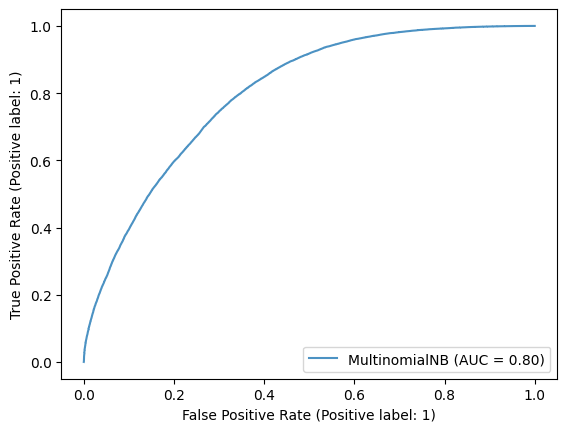

In [108]:
ax = plt.gca()
tfidf_nb = RocCurveDisplay.from_estimator(tfidf_nb, x_test_tfidf, y_other, ax=ax, alpha=0.8)

## 9.2 Logi

In [109]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x_train_tfidf, y_train)

/opt/anaconda3/envs/NLP/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [110]:
# generate predictions
lr_pre = lr.predict(x_test_tfidf)
print("Test accuracy", accuracy_score(y_other,lr_pre)*100)
print("F1 Score:", f1_score(y_other,lr_pre, average='macro'))
print(classification_report(y_other,lr_pre))

Test accuracy 72.64843228819214
F1 Score: 0.7252378161207798
              precision    recall  f1-score   support

           0       0.75      0.67      0.71     41999
           1       0.71      0.78      0.74     43444

    accuracy                           0.73     85443
   macro avg       0.73      0.73      0.73     85443
weighted avg       0.73      0.73      0.73     85443



In [111]:
# train multinomial logistics regression
#### Prepare the parameter value list for tuning
#### Set the range of Grid Search
param_grid = {'C': [0.1, 1, 10]}

#### Train the Logistic Regression model
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
# Use GridSearch to tune the hyperparameter
logreg = GridSearchCV(logreg, param_grid, cv=5, n_jobs=-1)
logreg.fit(x_train_tfidf, y_train)
# check the value of C
best_C_logreg = logreg.best_params_['C']
print(f"Best C for Logistic Regression: {best_C_logreg}")
# predict the test result
predictions_logreg = logreg.predict(x_test_tfidf)

/opt/anaconda3/envs/NLP/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/NLP/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

Best C for Logistic Regression: 1


/opt/anaconda3/envs/NLP/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [112]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_other, predictions_logreg))
print("F1 Score:", f1_score(y_other, predictions_logreg, average='macro'))
print(classification_report(y_other, predictions_logreg))

Accuracy: 0.7263672857928678
F1 Score: 0.7251744887194773
              precision    recall  f1-score   support

           0       0.75      0.67      0.71     41999
           1       0.71      0.78      0.74     43444

    accuracy                           0.73     85443
   macro avg       0.73      0.73      0.73     85443
weighted avg       0.73      0.73      0.73     85443



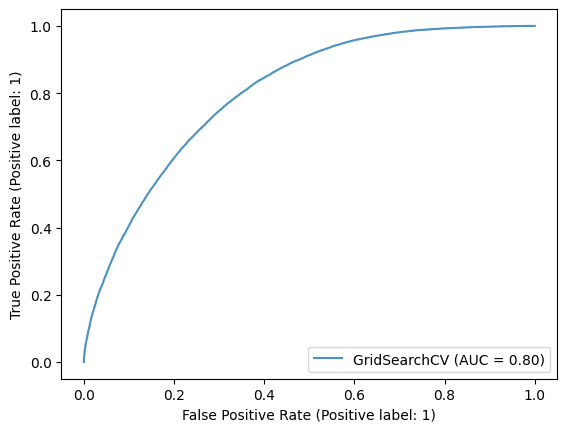

In [113]:
ax = plt.gca()
tfidf_lo = RocCurveDisplay.from_estimator(logreg, x_test_tfidf, y_other, ax=ax, alpha=0.8)

## 9.3 SVM

In [131]:
from sklearn import svm
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(x_train_tfidf, y_train)

predictions_SVM = SVM.predict(x_test_tfidf)
print("Test accuracy", accuracy_score(y_other,predictions_SVM)*100)
print("F1 Score:", f1_score(y_other,predictions_SVM, average='macro'))
print(classification_report(y_other,predictions_SVM))

## 9.4 Ridge

In [24]:
#### Prepar the parameter value list for tuning
#### Set the range of Grid Search
param_grid = {'alpha': [0.1, 1, 10]}

#### Train the Ridge Classification model
ridge_c = RidgeClassifier()
# Use GridSearch to tune the hyperparameter
ridge_c = GridSearchCV(ridge_c, param_grid, cv=5)
ridge_c.fit(x_train_tfidf, y_train)
# check the value of alpha
best_alpha_ridge = ridge_c.best_params_['alpha']
print(f"Best alpha for Ridge Regression: {best_alpha_ridge}")
# predict the test result
predictions_ridge = ridge_c.predict(x_test_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_other, predictions_ridge))
print("F1 Score:", f1_score(y_other, predictions_ridge, average='macro'))
print(classification_report(y_other, predictions_ridge))

Best alpha for Ridge Regression: 1
Accuracy: 0.7300422503891483
F1 Score: 0.7289848609218035
              precision    recall  f1-score   support

           0       0.75      0.68      0.71     41999
           1       0.72      0.78      0.75     43444

    accuracy                           0.73     85443
   macro avg       0.73      0.73      0.73     85443
weighted avg       0.73      0.73      0.73     85443



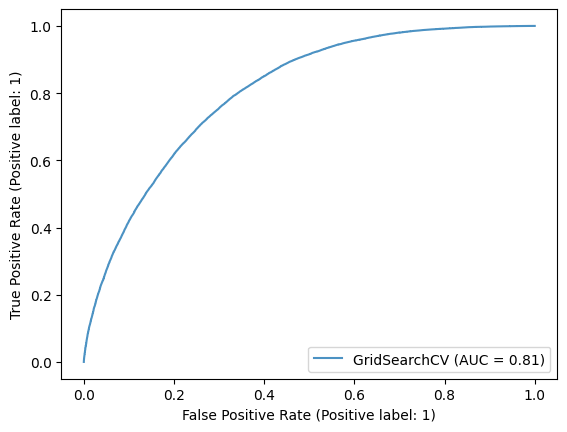

In [105]:
ax = plt.gca()
tfidf_ridge = RocCurveDisplay.from_estimator(ridge_c, x_test_tfidf, y_other, ax=ax, alpha=0.8)

# 10. Word2vec

In [83]:
from gensim.models import Word2Vec

sentences = [sentence.split() for sentence in x_train]
w2v_model = Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)

In [84]:
import numpy as np

def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

x_train_w2v = np.array([vectorize(sentence) for sentence in x_train])
x_test_w2v = np.array([vectorize(sentence) for sentence in x_other])

## 10.1 Ridge

In [114]:
#### Prepar the parameter value list for tuning
#### Set the range of Grid Search
param_grid = {'alpha': [0.1, 1, 10]}

#### Train the Ridge Classification model
ridge_c = RidgeClassifier()
# Use GridSearch to tune the hyperparameter
ridge_c = GridSearchCV(ridge_c, param_grid, cv=5)
ridge_c.fit(x_train_w2v, y_train)
# check the value of alpha
best_alpha_ridge = ridge_c.best_params_['alpha']
print(f"Best alpha for Ridge Regression: {best_alpha_ridge}")
# predict the test result
predictions_ridge = ridge_c.predict(x_test_w2v)

# Evaluate the model
print("Accuracy:", accuracy_score(y_other, predictions_ridge))
print("F1 Score:", f1_score(y_other, predictions_ridge, average='macro'))
print(classification_report(y_other, predictions_ridge))

Best alpha for Ridge Regression: 10
Accuracy: 0.6767786711608909
F1 Score: 0.6762159538194475
              precision    recall  f1-score   support

           0       0.68      0.65      0.66     41999
           1       0.67      0.71      0.69     43444

    accuracy                           0.68     85443
   macro avg       0.68      0.68      0.68     85443
weighted avg       0.68      0.68      0.68     85443



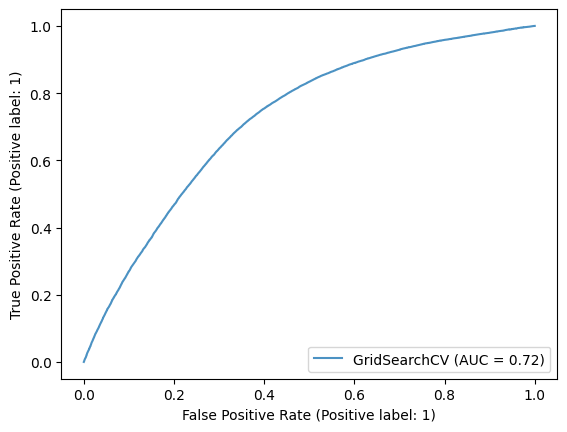

In [115]:
ax = plt.gca()
word_ridge = RocCurveDisplay.from_estimator(ridge_c, x_test_w2v, y_other, ax=ax, alpha=0.8)

## 10.1 Logi

In [116]:
clf = LogisticRegression()
clf.fit(x_train_w2v, y_train)

LogisticRegression()

In [117]:
# generate predictions
lr_pre = clf.predict(x_test_w2v)
print("Test accuracy", accuracy_score(y_other,lr_pre)*100)
print("F1 Score:", f1_score(y_other,lr_pre, average='macro'))
print(classification_report(y_other,lr_pre))

Test accuracy 67.82182273562492
F1 Score: 0.6777033732283362
              precision    recall  f1-score   support

           0       0.68      0.65      0.66     41999
           1       0.68      0.71      0.69     43444

    accuracy                           0.68     85443
   macro avg       0.68      0.68      0.68     85443
weighted avg       0.68      0.68      0.68     85443



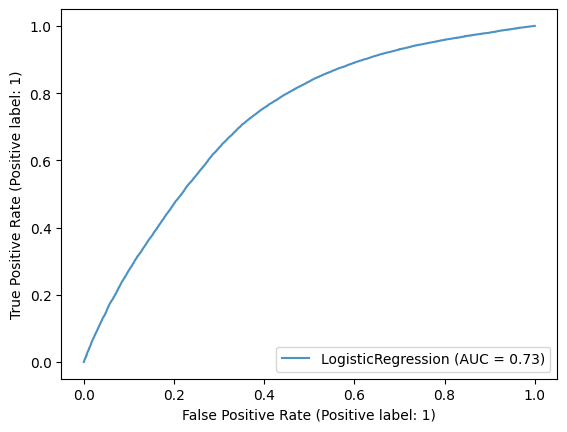

In [119]:
ax = plt.gca()
word_lo = RocCurveDisplay.from_estimator(clf, x_test_w2v, y_other, ax=ax, alpha=0.8)

## 10.2 XGB

In [61]:
from xgboost import XGBClassifier

xgb = XGBClassifier(learning_rate=0.01, n_estimators=100, n_jobs=-1)

In [67]:
xgb.fit(x_train_w2v, y_train)

KeyboardInterrupt: 

In [ ]:
# generate predictions
xgb_pre = xgb.predict(x_test_w2v)
print("Test accuracy", accuracy_score(y_other,xgb_pre)*100)
print("F1 Score:", f1_score(y_other,xgb_pre, average='macro'))
print(classification_report(y_other,xgb_pre))

## 10.3 DL

In [85]:
max_words = 100
# tokenize = text.Tokenizer(num_words=max_words, char_level=False)
# tokenize.fit_on_texts(train_posts) # only fit on train

# x_train = tokenize.texts_to_matrix(train_posts)
# x_test = tokenize.texts_to_matrix(test_posts)

# encoder = LabelEncoder()
# encoder.fit(train_tags)
# y_train = encoder.transform(train_tags)
# y_test = encoder.transform(test_tags)

# num_classes = np.max(y_train) + 1
# y_train = utils.to_categorical(y_train, num_classes)
# y_test = utils.to_categorical(y_test, num_classes)

batch_size = 32
epochs = 10

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(x_train_w2v, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1) # validation_data=(x_val, y_val)

Epoch 1/10
9613/9613 [==============================] - 26s 3ms/step - loss: 0.6067 - accuracy: 0.6784 - val_loss: 0.5914 - val_accuracy: 0.6900
Epoch 2/10
9613/9613 [==============================] - 42s 4ms/step - loss: 0.5965 - accuracy: 0.6870 - val_loss: 0.5888 - val_accuracy: 0.6870
Epoch 3/10
9613/9613 [==============================] - 33s 3ms/step - loss: 0.5939 - accuracy: 0.6886 - val_loss: 0.5870 - val_accuracy: 0.6892
Epoch 4/10
9613/9613 [==============================] - 26s 3ms/step - loss: 0.5915 - accuracy: 0.6908 - val_loss: 0.5853 - val_accuracy: 0.6894
Epoch 5/10
9613/9613 [==============================] - 27s 3ms/step - loss: 0.5909 - accuracy: 0.6909 - val_loss: 0.5841 - val_accuracy: 0.6931
Epoch 6/10
9613/9613 [==============================] - 31s 3ms/step - loss: 0.5900 - accuracy: 0.6923 - val_loss: 0.5836 - val_accuracy: 0.6922
Epoch 7/10
9613/9613 [==============================] - 34s 4ms/step - loss: 0.5888 - accuracy: 0.6925 - val_loss: 0.5900 - val_ac

In [125]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


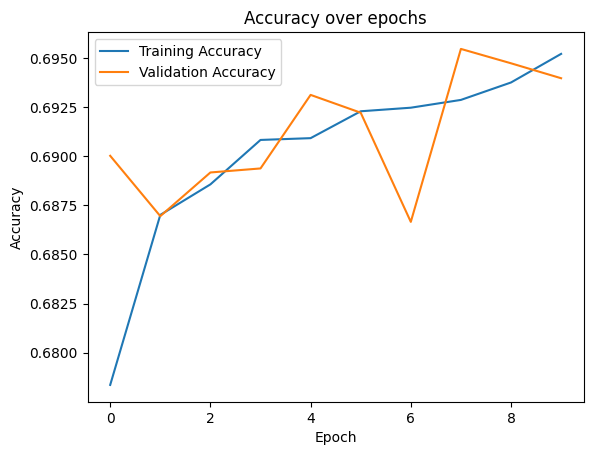

In [86]:
#### Visualise the accuracy change
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

In [93]:
x_test_w2v_dl = np.array([vectorize(sentence) for sentence in x_test])

In [96]:
score = model.evaluate(x_test_w2v_dl, y_test)
print('Test accuracy:', score[1])

  17/2137 [..............................] - ETA: 6s - loss: 0.5700 - accuracy: 0.6985  

2137/2137 [==============================] - 6s 3ms/step - loss: 0.5846 - accuracy: 0.6934
Test accuracy: 0.6934487819671631


In [97]:
y_pred_probs = model.predict(x_test_w2v_dl, verbose=0)
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to class labels

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='binary')
print("F1 Score:", f1)

F1 Score: 0.7204045687446626


In [121]:
auc_score = roc_auc_score(y_test, y_pred)

In [122]:
auc_score

0.692166497697146

# 11. Doc2vec

In [107]:
# convert data into Doc2Vec required format
tgd_X = [TaggedDocument(d, [i]) for i, d in enumerate(docs_phrased_brand)]

# train Doc2Vec model
model = Doc2Vec(tgd_X, vector_size=100, min_count=1, workers=4, epochs=100)

# get Doc2Vec vectors
vectors = [model.infer_vector(x) for x in tqdm(docs_phrased_brand)]
vectors = [x.tolist() for x in vectors]

# train-test split
X_other, X_test, y_other, y_test = train_test_split(vectors, Y, test_size=0.2,random_state = 11)

  0%|          | 0/427211 [00:00<?, ?it/s]

In [108]:
clf = LogisticRegression()
clf.fit(X_other, y_other)

LogisticRegression()

In [109]:
# generate predictions
lr_pre = clf.predict(X_test)
print("Test accuracy", accuracy_score(y_test,lr_pre)*100)
print("F1 Score:", f1_score(y_test,lr_pre, average='macro'))
print(classification_report(y_test,lr_pre))

Test accuracy 65.94805893987805
F1 Score: 0.6553176775171069
              precision    recall  f1-score   support

           0       0.69      0.56      0.62     42098
           1       0.64      0.76      0.69     43345

    accuracy                           0.66     85443
   macro avg       0.66      0.66      0.66     85443
weighted avg       0.66      0.66      0.66     85443



# Prediction prepare data

In [ ]:
######### use Ridge #########

In [103]:
sp_pre_eu = df1[df1['Location'].isnull()]

In [106]:
docs = sp_pre_eu["Comment"]

In [28]:
# no label predict
ml_pre_eu = ml1[ml1['user_continent'].isnull()]
ml_pre_eu = ml_pre_eu.dropna(subset="content")

# NLP pipeline

In [30]:
docs = ml_pre_eu["content"]

In [107]:
docs_tokens = []
tmp = []
for doc in tqdm(docs):
    tmp = [
        token.lemma_.lower()
        for token in nlp(doc)
        if (not token.is_stop) & 
        (not token.is_punct) & 
        (token.is_alpha)
    ]
    
    docs_tokens.append(tmp)

  0%|          | 0/126139 [00:00<?, ?it/s]

In [108]:
# find bigrams and trigrams

# get rid of common terms
common_terms = [
    u"of",
    u"with",
    u"without",
    u"and",
    u"or",
    u"the",
    u"a",
    u"not",
    "be",
    u"to",
    u"this",
    u"who",
    u"in",
]
# find phrases
bigram = Phrases( # capturing bi-grams
    docs_tokens,
    min_count=50,
    threshold=5,
    max_vocab_size=50000,
    common_terms=common_terms,
)
trigram = Phrases( # capturing tri-grams
    bigram[docs_tokens],
    min_count=50,
    threshold=5,
    max_vocab_size=50000,
    common_terms=common_terms,
)

# uncomment if bi-grammed, tokenized document is preferred

# docs_phrased = [bigram[line] for line in docs_tokens]
docs_phrased_brand = [trigram[bigram[line]] for line in docs_tokens] # tokenized documents and join 
                                                                # the tokens associated with 
                                                                # bi- or tri-grams.

In [32]:
# load tokens
with open('/Users/irene/CloudStation/Courses/ARP/ARP code/Maserati-ARP/Maserati-ARP/Data-analysis/masratilife_LC_original_label.pkl', 'rb') as f:
    docs_phrased_brand = pickle.load(f)

In [34]:
test = [' '.join(t) for t in docs_phrased_brand]
ml_pre_eu1 = ml_pre_eu.copy()
ml_pre_eu1['content'] = test

In [110]:
test = [' '.join(t) for t in docs_phrased_brand]
sp_pre_eu1 = sp_pre_eu.copy()
sp_pre_eu1['Comment'] = test

# Predict Euro

In [36]:
def predict_eu(x_data):
    predata_tfidf = tfidf.transform(x_data)
    eu_predictions_ridge = ridge_c.predict(predata_tfidf)
    return eu_predictions_ridge

# MaseratiLife

In [37]:
ml_eu_y = predict_eu(ml_pre_eu1['content'])

In [40]:
ml_pre_eu1["europe"] = ml_eu_y

In [43]:
ml_pre_eu1 = ml_pre_eu1[["content",'europe']]

In [44]:
ml_pre_eu1

,content,europe
1,hi vandalisim incident quatroporte look passen...,0
3,year qp,1
10,need set date meet carolina motorsport park aw...,0
11,jeef hi want ask thing streaked headlight look...,0
21,anybody experience quattroporte ecm unit notic...,0
...,...,...
291874,k big deal agree cheap well sure company work ...,1
291875,objective fact maserati subsidiary want sell c...,0
291877,hyundai genesis well ghibli,0
291880,honestly understand clueless person like maser...,0


# NLP pipeline

In [46]:
# with original lable
ml3

,Comment,europe
0,Just wanted to send a thank you note to Cyril ...,0
2,"Sorry to hear about that, if you're able to em...",0
4,"Jeff,,Thank you for being a super resource and...",1
5,So I keep hearing and seeing all this great ne...,0
6,I spoke briefly to Larini last year and they m...,0
...,...,...
291881,I'm all for the funny back and forth as long a...,0
291882,"A fair statement.,A few months ago I bought a ...",1
291884,"No, you don't remember correctly. You've been ...",1
291885,Which is awesome IMO. It means their product i...,0


In [47]:
docs = ml3["Comment"]

In [48]:
nlp = spacy.load("en_core_web_lg")

In [49]:
docs_tokens = []
tmp = []
for doc in tqdm(docs):
    tmp = [
        token.lemma_.lower()
        for token in nlp(doc)
        if (not token.is_stop) & 
        (not token.is_punct) & 
        (token.is_alpha)
    ]
    
    docs_tokens.append(tmp)

  0%|          | 0/161742 [00:00<?, ?it/s]

In [50]:
# find bigrams and trigrams

# get rid of common terms
common_terms = [
    u"of",
    u"with",
    u"without",
    u"and",
    u"or",
    u"the",
    u"a",
    u"not",
    "be",
    u"to",
    u"this",
    u"who",
    u"in",
]
# find phrases
bigram = Phrases( # capturing bi-grams
    docs_tokens,
    min_count=50,
    threshold=5,
    max_vocab_size=50000,
    common_terms=common_terms,
)
trigram = Phrases( # capturing tri-grams
    bigram[docs_tokens],
    min_count=50,
    threshold=5,
    max_vocab_size=50000,
    common_terms=common_terms,
)

# uncomment if bi-grammed, tokenized document is preferred

# docs_phrased = [bigram[line] for line in docs_tokens]
docs_phrased_brand = [trigram[bigram[line]] for line in docs_tokens] # tokenized documents and join 
                                                                # the tokens associated with 
                                                                # bi- or tri-grams.

In [ ]:
# save the list of tokens
with open('maseratilife_with_label.pkl', 'wb') as f:
    pickle.dump(docs_phrased_brand, f)

In [ ]:
# load tokens
with open('maseratilife_with_label.pkl', 'rb') as f:
    docs_phrased_brand = pickle.load(f)

In [58]:
docs_phrased_brand

[['want',
  'send',
  'thank',
  'note',
  'cyril',
  'formula_dynamics',
  'excellent',
  'support',
  'certainly',
  'order',
  'credit',
  'card',
  'issue',
  'sort',
  'go',
  'extreamly',
  'smoth',
  'come',
  'order',
  'number',
  'short',
  'sport',
  'gt',
  'bianco_fuji',
  'cuchio',
  'porsche',
  'cayenne',
  's',
  'black',
  'beige'],
 ['sorry',
  'hear',
  'able',
  'email',
  'vin',
  'part',
  'need',
  'quote',
  'new',
  'original',
  'maserati',
  'part',
  'option',
  'typically',
  'salvage',
  'yard',
  'maserati',
  'qp',
  'vintage',
  'luck',
  'let',
  'know',
  'help'],
 ['super',
  'resource',
  'service',
  'provider',
  'moment',
  'purchase',
  'car',
  'summer',
  'personally',
  'instal',
  'dbw',
  'take',
  'apart',
  'wiring',
  'fix',
  'notice',
  'previous',
  'owner',
  'amateur',
  'job',
  'tap',
  'wire',
  'ipod',
  'adapter',
  'help',
  'provide',
  'answer',
  'question',
  'supply',
  'performance',
  'part',
  'wait',
  'dbw',
  'perf

In [60]:
e = [' '.join(t) for t in docs_phrased_brand]

['want send thank note cyril formula_dynamics excellent support certainly order credit card issue sort go extreamly smoth come order number short sport gt bianco_fuji cuchio porsche cayenne s black beige',
 'sorry hear able email vin part need quote new original maserati part option typically salvage yard maserati qp vintage luck let know help',
 'super resource service provider moment purchase car summer personally instal dbw take apart wiring fix notice previous owner amateur job tap wire ipod adapter help provide answer question supply performance part wait dbw performance ecm update harness configure ron dubai plus de cat h pipe performance filter iridium plug rabid beast wait great resource thank walk local shop process uninstalle',
 'hear see great new stuff problem damn thing biturbo jeff notch touch old buy vw engine day probably go find way kid aside get great fd product instal customer car year look forward good work boy',
 'speak briefly larini year mention like produce opti

In [66]:
ml3["Comment"] = e

In [68]:
ml3 = ml3.rename(columns={"Comment": "content"})

In [55]:
ml_pre_eu1

,content,europe
1,hi vandalisim incident quatroporte look passen...,0
3,year qp,1
10,need set date meet carolina motorsport park aw...,0
11,jeef hi want ask thing streaked headlight look...,0
21,anybody experience quattroporte ecm unit notic...,0
...,...,...
291874,k big deal agree cheap well sure company work ...,1
291875,objective fact maserati subsidiary want sell c...,0
291877,hyundai genesis well ghibli,0
291880,honestly understand clueless person like maser...,0


In [69]:
ml3

,content,europe
0,want send thank note cyril formula_dynamics ex...,0
2,sorry hear able email vin part need quote new ...,0
4,super resource service provider moment purchas...,1
5,hear see great new stuff problem damn thing bi...,0
6,speak briefly larini year mention like produce...,0
...,...,...
291881,funny forth long connection car simple calling...,0
291882,fair statement month ago buy brand new grantur...,1
291884,remember correctly tell time figure mention li...,1
291885,awesome imo mean product resonate cool fifth g...,0


In [70]:
data_list = [ml_pre_eu1, ml3]
masratilife_EU = pd.concat(data_list)

In [71]:
masratilife_EU

,content,europe
1,hi vandalisim incident quatroporte look passen...,0
3,year qp,1
10,need set date meet carolina motorsport park aw...,0
11,jeef hi want ask thing streaked headlight look...,0
21,anybody experience quattroporte ecm unit notic...,0
...,...,...
291881,funny forth long connection car simple calling...,0
291882,fair statement month ago buy brand new grantur...,1
291884,remember correctly tell time figure mention li...,1
291885,awesome imo mean product resonate cool fifth g...,0


In [138]:
masratilife_EU.to_csv("masratilife_EU.csv", index=False)

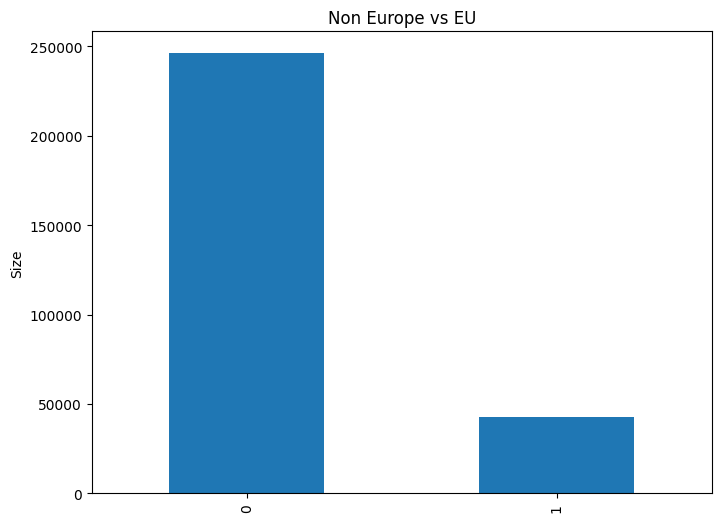

In [100]:
fig, ax = plt.subplots(figsize=(8, 6))
r = masratilife_EU.groupby(["europe"]).size()
r.plot(kind = "bar", ax = ax)
ax.set_xlabel("")
ax.set_ylabel("Size")
ax.set_title("Non Europe vs EU")
plt.xticks(fontsize=10)
plt.show()

In [101]:
r

europe
0    246088
1     42840
dtype: int64

# Sportmaserati

In [111]:
sp_eu_y = predict_eu(sp_pre_eu1['Comment'])

In [112]:
sp_pre_eu1["europe"] = sp_eu_y

In [113]:
sp_pre_eu1 = sp_pre_eu1[["Comment",'europe']]

In [122]:
df34 = df3[["Comment",'europe']]

In [123]:
data_list = [sp_pre_eu1, df34]
sportmaserati_EU = pd.concat(data_list)

In [258]:
sportmaserati_EU

,Comment,europe
11,wonder necessary handle power super car day ri...,0
12,mid late japanese motorbike industry create vo...,0
14,oh v max blow limit couple year later think st...,1
16,guy sound like constant job interview mid gear...,1
22,enjoy watch throttle house,1
...,...,...
391603,not find bad think twice junction honest round...,1
391604,drive abroad usually drive continent time year...,1
391605,accident happen junction look right instead le...,0
391606,having spend year driving life work iran yearl...,0


In [289]:
s0 = sp_pre_eu1.rename(columns={"Comment":"tokens"})
s1 = [sp_pre_eu["Comment"], s0]
spre1 = pd.concat(s1,axis=1)

In [290]:
spre1

,Comment,tokens,europe
11,Wondering if it's necessary to handle all this...,wonder necessary handle power super car day ri...,0
12,Mid/late 80's the Japanese motorbike industry ...,mid late japanese motorbike industry create vo...,0
14,Oh it was the V-MAX that blew through the limi...,oh v max blow limit couple year later think st...,1
16,the guy still sounds like he’s on a constant j...,guy sound like constant job interview mid gear...,1
22,I enjoy watching throttle house,enjoy watch throttle house,1
...,...,...,...
391581,"Hi everyone,glad to be onboard this forum,be g...",hi glad onboard forum good emblem meet saturda...,1
391583,"Thanks UM, perhaps it'll be OK.I'll try the 'f...",thank um try faith thing oh ho sun come impress,1
391584,Saw this in the car park the other day. How wr...,see car park day wrong maybe throw citroen own...,1
391588,No! no mid ground there...the Kia doesnt look ...,mid ground kia not look bad squint pace little...,1


In [282]:
dddd = df34.rename(columns={"Comment":"tokens"})

In [271]:
ss = sp[["Comment","europe"]]

In [284]:
aaaa = dddd["tokens"]

In [285]:
rr = [aaaa,ss]
ee = pd.concat(rr,axis=1)

In [291]:
s1 = [spre1,ee]
sent = pd.concat(s1)

In [292]:
sent

,Comment,tokens,europe
11,Wondering if it's necessary to handle all this...,wonder necessary handle power super car day ri...,0
12,Mid/late 80's the Japanese motorbike industry ...,mid late japanese motorbike industry create vo...,0
14,Oh it was the V-MAX that blew through the limi...,oh v max blow limit couple year later think st...,1
16,the guy still sounds like he’s on a constant j...,guy sound like constant job interview mid gear...,1
22,I enjoy watching throttle house,enjoy watch throttle house,1
...,...,...,...
391603,I dont find it too bad. You have to think twic...,not find bad think twice junction honest round...,1
391604,"First drove abroad in 1981, usually drive on c...",drive abroad usually drive continent time year...,1
391605,Most accidents happen at junctions where you l...,accident happen junction look right instead le...,0
391606,Having spent the first 5 years of my driving l...,having spend year driving life work iran yearl...,0


In [293]:
sent.to_csv("sent.csv")